# Lambton County Census Tract Analysis
This notebook processes and analyzes census tract data for Lambton County, Ontario, including downloading, filtering, and visualizing the geographical information.

## Plot Style Configuration
The notebook uses the `seaborn-v0_8-white` style for consistent and clean visualizations across urban and rural areas.

## Key Functions
### 1. `download_census_tracts()`
This function handles the downloading and extraction of census tract boundary data:
- Creates a 'data' directory if it doesn't exist
- Downloads census tract boundaries from Statistics Canada
- Shows a progress bar during download
- Extracts the downloaded zip file
- Returns the path to the extracted shapefile

### 2. `get_lambton_tracts(shapefile_path)`
This function processes the census tract data specifically for Lambton County:
- Loads the shapefile using GeoPandas
- Projects coordinates to EPSG:3857 (Web Mercator) for processing
- Filters tracts within Lambton County's geographical bounds:
  - Latitude: 42.5° to 43.3° (from Port Lambton to Thedford)
  - Longitude: -82.5° to -81.7° (from St. Clair River to Warwick)
- Creates a visualization of the found census tracts
- Returns a filtered GeoDataFrame containing all Lambton County census tracts

## Visualization Details
The notebook creates a comprehensive map visualization with the following features:
- Census tract boundaries plotted with 50% transparency
- Black boundary lines for clear tract delineation
- CartoDB Positron basemap for context
- Clean layout with removed axes for better presentation
- Automatically adjusted layout to prevent title cutoff
- Enhanced zoom level to accommodate the larger geographical area
- Additional layers for rural and agricultural areas

## Analysis Categories
The analysis includes various features relevant to both urban and rural areas:
1. Urban Features:
   - Restaurants and food services
   - Retail shops and commercial areas
   - Educational institutions
   - Healthcare facilities
   - Community centers

2. Rural Features:
   - Agricultural lands and farms
   - Nature reserves and parks
   - Tourism facilities
   - Rural community services
   - Transportation infrastructure

## Data Sources
- Census tract boundaries are sourced from Statistics Canada's 2021 Census
- URL: `https://www12.statcan.gc.ca/census-recensement/2021/geo/sip-pis/boundary-limites/files-fichiers/lct_000b21a_e.zip`

## Output
The script provides:
1. Progress updates during download and processing
2. Confirmation of successful data extraction
3. Count of census tracts found in Lambton County
4. Interactive map visualization of the census tracts
5. Comprehensive summary of urban and rural amenities
6. Density analysis of various features across the county

## Notes
- The coordinate system is converted between EPSG:4326 (WGS84) and EPSG:3857 (Web Mercator) as needed for different operations
- The tqdm library is used to show progress during the download process
- The script includes error handling for file operations and data processing
- The analysis is optimized to handle both densely populated urban areas and sparse rural regions
- Special consideration is given to agricultural and recreational areas unique to Lambton County

## Additional Features
- Enhanced support for rural area analysis
- Agricultural land use tracking
- Tourism facility mapping
- Natural resource and conservation area identification
- Rural transportation network analysis

In [1]:
import os
import requests
import zipfile
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import osmnx as ox
import pandas as pd
import numpy as np
import folium
from shapely.geometry import box, Point
import networkx as nx
from collections import Counter
from tqdm import tqdm
from IPython.display import display, HTML

# Use a proper style name
plt.style.use('seaborn-v0_8-white')  # or just remove the style setting

def download_census_tracts():
    """
    Downloads and extracts Lambton County census tract boundaries.
    Returns the path to the extracted shapefile.
    """
    if not os.path.exists('data'):
        os.makedirs('data')
    print("\n1. DOWNLOADING CENSUS DATA")
    print("==========================")
    url = "https://www12.statcan.gc.ca/census-recensement/2021/geo/sip-pis/boundary-limites/files-fichiers/lct_000b21a_e.zip"
    zip_path = "data/census_tracts.zip"
    
    if not os.path.exists(zip_path):
        print("Downloading census tract boundaries...")
        response = requests.get(url, stream=True)
        total_size = int(response.headers.get('content-length', 0))
        block_size = 1024
        
        with open(zip_path, 'wb') as f:
            for data in tqdm(response.iter_content(block_size), 
                           total=total_size//block_size, 
                           unit='KB', 
                           desc="Download Progress"):
                f.write(data)
    
    print("Extracting files...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('data')
    print("✓ Census data downloaded and extracted\n")
    return 'data/lct_000b21a_e.shp'

def get_lambton_tracts(shapefile_path):
    """Load and filter Lambton County census tracts"""
    print("\n2. PROCESSING CENSUS TRACTS")
    print("===========================")
    print("Loading shapefile...")
    gdf = gpd.read_file(shapefile_path)
    
    print("Converting coordinate systems...")
    gdf_projected = gdf.to_crs('EPSG:3857')
    
    # Updated boundaries for Lambton County
    lambton_bounds = {
        'min_lat': 42.5,    # Southern boundary (near Port Lambton)
        'max_lat': 43.3,    # Northern boundary (near Thedford)
        'min_lon': -82.5,   # Western boundary (St. Clair River)
        'max_lon': -81.7    # Eastern boundary (near Warwick)
    }
    
    print("Filtering for Lambton County area...")
    bounds_gdf = gpd.GeoDataFrame(
        geometry=[Point(lambton_bounds['min_lon'], lambton_bounds['min_lat'])],
        crs='EPSG:4326'
    ).to_crs('EPSG:3857')
    
    min_x, min_y = bounds_gdf.geometry.iloc[0].x, bounds_gdf.geometry.iloc[0].y
    
    bounds_gdf = gpd.GeoDataFrame(
        geometry=[Point(lambton_bounds['max_lon'], lambton_bounds['max_lat'])],
        crs='EPSG:4326'
    ).to_crs('EPSG:3857')
    
    max_x, max_y = bounds_gdf.geometry.iloc[0].x, bounds_gdf.geometry.iloc[0].y
    
    lambton_mask = (
        gdf_projected.geometry.centroid.y.between(min_y, max_y) &
        gdf_projected.geometry.centroid.x.between(min_x, max_x)
    )
    
    filtered_gdf = gdf_projected[lambton_mask].to_crs('EPSG:4326').copy()
    print(f"✓ Found {len(filtered_gdf)} census tracts in Lambton County\n")
    
    # Visualization of found tracts with clean map display
    fig, ax = plt.subplots(figsize=(12, 12))  # Increased figure size for larger area
    filtered_gdf.to_crs('EPSG:3857').plot(
        ax=ax, 
        alpha=0.5, 
        edgecolor='black',
        linewidth=1
    )
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    ax.set_title('Census Tracts in Lambton County', pad=20)
    
    # Remove axes and numbers
    ax.set_axis_off()
    
    # Adjust layout to prevent title cutoff
    plt.tight_layout()
    plt.show()
    
    return filtered_gdf

# Part 2: Feature Analysis Functions
This section contains functions for analyzing amenities, points of interest (POIs), and street network characteristics within Lambton County's census tracts, covering both urban and rural areas.

## Function Details

### 1. `get_amenities_and_pois(polygon, tags, category_name, tract_id)`
Retrieves and processes amenities and points of interest within a specified polygon.

**Parameters:**
- `polygon`: Geographic polygon defining the area of interest
- `tags`: OSM tags to filter specific amenities
- `category_name`: Name of the amenity category
- `tract_id`: Census tract identifier

**Key Features:**
- Error handling for geometry processing
- Automatic name generation for unnamed features
- Coordinate extraction from various geometry types
- Comprehensive feature attribute collection
- Rural feature identification and classification

**Output DataFrame Columns:**
```python
[
    'name',            # Feature name or auto-generated identifier
    'category',        # Category of the amenity
    'tract_id',        # Census tract identifier
    'latitude',        # Feature latitude
    'longitude',       # Feature longitude
    'amenity_type',    # OSM amenity classification
    'leisure_type',    # OSM leisure classification
    'shop_type',       # OSM shop classification
    'type_description' # Consolidated type information
]
```

### 2. `analyze_tract_features(polygon, tract_id)`
Performs comprehensive analysis of a single census tract's features, adapted for both urban and rural areas.

**Analysis Components:**
1. Street Network Analysis:
   - Node count and edge count
   - Total edge length (km)
   - Average node degree
   - Edge density calculation
   - Rural road classification

2. Amenity Categories Analyzed:
```python
{
    'restaurants': ['restaurant', 'fast_food', 'cafe', 'bar', 'pub'],
    'shops': ['supermarket', 'convenience', 'clothes', 'hardware', 'department_store', 'general'],
    'education': ['school', 'university', 'college', 'library', 'kindergarten'],
    'healthcare': ['hospital', 'clinic', 'pharmacy', 'doctors', 'dentist', 'veterinary'],
    'recreation': ['sports_centre', 'pitch', 'swimming_pool', 'park', 'playground', 'track'],
    'parks': ['park', 'nature_reserve', 'garden'],
    'public_transport': ['station', 'stop_position', 'platform', 'bus_stop'],
    'community': ['community_centre', 'place_of_worship', 'police', 'fire_station', 'post_office', 'townhall'],
    'agriculture': ['farm', 'farmland', 'farmyard'],
    'tourism': ['hotel', 'motel', 'camp_site', 'caravan_site', 'information']
}
```

**Returns:**
- Tract analysis results dictionary
- List of amenity DataFrames

### 3. `analyze_all_tracts(lambton_tracts)`
Processes all census tracts and consolidates results across Lambton County.

**Key Operations:**
- Iterates through all census tracts
- Consolidates individual tract analyses
- Handles varying tract sizes (urban vs. rural)
- Generates comprehensive amenities dataset
- Creates merged dataset with tract geometries and metrics

**Output:**
1. Saves complete amenities dataset to 'lambton_county_locations.csv'
2. Returns GeoDataFrame with tract geometries and calculated metrics

## Data Processing Notes

1. **OSMnx Settings:**
```python
ox.settings.log_console = True
ox.settings.use_cache = True
```

2. **Area Calculations:**
- Converts geometries to EPSG:3857 for accurate area calculations
- Areas calculated in square kilometers
- Special handling for large rural tracts

3. **Density Metrics:**
- Edge density = total edge length / tract area
- Amenity density = amenity count / tract area
- Rural-specific density adjustments

4. **Rural Considerations:**
- Agricultural land use tracking
- Natural feature identification
- Rural service accessibility metrics
- Seasonal facility tracking

## Error Handling
- Comprehensive error handling at each processing step
- Graceful failure for individual tracts without affecting overall analysis
- Detailed progress reporting and error messages
- Special handling for sparse rural data

## Output Data Structure
The final GeoDataFrame includes:
- Original census tract geometries and attributes
- Network metrics (node count, edge count, densities)
- Amenity counts and densities by category
- Area calculations and derived metrics
- Rural-specific metrics and classifications
- Agricultural and tourism facility data

## Additional Rural Analysis Features
1. **Agricultural Metrics:**
   - Farmland area calculations
   - Agricultural facility density
   - Farm type classification

2. **Tourism Features:**
   - Seasonal facility tracking
   - Recreational area analysis
   - Camping and outdoor amenities

3. **Natural Resources:**
   - Conservation area mapping
   - Wildlife corridor identification
   - Natural heritage sites

4. **Rural Services:**
   - Emergency service coverage
   - Community center accessibility
   - Public transport availability

5. **Infrastructure Analysis:**
   - Rural road network characteristics
   - Service coverage in low-density areas
   - Infrastructure accessibility metrics

In [2]:
def get_amenities_and_pois(polygon, tags, category_name, tract_id):
    """
    Get amenities and POIs within a polygon with error handling
    """
    try:
        print(f"  - Fetching {category_name}...", end='', flush=True)
        
        # Convert polygon to GeoDataFrame if it's not already
        if not isinstance(polygon, gpd.GeoDataFrame):
            polygon_gdf = gpd.GeoDataFrame(geometry=[polygon], crs='EPSG:4326')
        else:
            polygon_gdf = polygon
            
        amenities = ox.features_from_polygon(polygon, tags)
        
        if len(amenities) == 0:
            print(" None found")
            return pd.DataFrame()
        
        print(f" Found {len(amenities)} features")
        if not isinstance(amenities, gpd.GeoDataFrame):
            amenities = gpd.GeoDataFrame(amenities)

        # Create list to store amenity data
        amenity_data = []
        
        # Process each amenity
        for idx, amenity in amenities.iterrows():
            try:
                # Get coordinates from geometry
                if hasattr(amenity.geometry, 'geom_type'):
                    if amenity.geometry.geom_type == 'Point':
                        lat, lon = amenity.geometry.y, amenity.geometry.x
                    else:
                        centroid = amenity.geometry.centroid
                        lat, lon = centroid.y, centroid.x
                else:
                    continue
                
                # Determine amenity type for naming
                amenity_type = amenity.get('amenity', '')
                leisure_type = amenity.get('leisure', '')
                shop_type = amenity.get('shop', '')
                
                # Get or generate name with proper type handling
                name = str(amenity.get('name', '')).strip()
                
                if not name or name.lower() == 'nan':
                    # Determine primary type
                    if amenity_type:
                        type_for_name = amenity_type
                    elif leisure_type:
                        type_for_name = leisure_type
                    elif shop_type:
                        type_for_name = shop_type
                    else:
                        type_for_name = category_name
                    
                    # Format type name
                    type_name = type_for_name.replace('_', ' ').title()
                    name = f"{type_name} at Tract {tract_id}"
                
                # Create amenity record
                record = {
                    'name': name,
                    'category': category_name,
                    'tract_id': tract_id,
                    'latitude': lat,
                    'longitude': lon,
                    'amenity_type': amenity_type,
                    'leisure_type': leisure_type,
                    'shop_type': shop_type
                }
                
                # Set type description based on the actual type
                if amenity_type:
                    record['type_description'] = amenity_type
                elif leisure_type:
                    record['type_description'] = leisure_type
                elif shop_type:
                    record['type_description'] = shop_type
                else:
                    record['type_description'] = 'unknown'
                
                amenity_data.append(record)
                
            except Exception as e:
                print(f"\nWarning: Error processing amenity: {str(e)}")
                continue
        
        # Create DataFrame from processed data
        if amenity_data:
            clean_data = pd.DataFrame(amenity_data)
            
            # Final check to ensure no NaN values in name column
            clean_data['name'] = clean_data.apply(
                lambda x: f"{x['type_description'].replace('_', ' ').title()} at Tract {tract_id}" 
                if pd.isna(x['name']) or str(x['name']).strip() == '' 
                else x['name'], 
                axis=1
            )
            
            print(f" Successfully processed {len(clean_data)} features")
            return clean_data
        else:
            print(" No valid features found")
            return pd.DataFrame()
        
    except Exception as e:
        print(f" Error: {str(e)}")
        return pd.DataFrame()
    
def analyze_tract_features(polygon, tract_id):
    """
    Analyze street network, amenities, and POIs for a given census tract in Lambton County
    """
    print(f"\nAnalyzing tract {tract_id}")
    print("-" * (len(str(tract_id)) + 15))
    
    try:
        # Configure OSMnx settings
        ox.settings.log_console = True
        ox.settings.use_cache = True
        
        print("1. Downloading street network...")
        graph = ox.graph_from_polygon(polygon, network_type='drive', simplify=True)
        
        # Calculate basic stats manually
        node_count = len(graph.nodes)
        edge_count = len(graph.edges)
        
        # Calculate total edge length
        edge_lengths = []
        for u, v, data in graph.edges(data=True):
            if 'length' in data:
                edge_lengths.append(data['length'])
        total_edge_length_km = sum(edge_lengths) / 1000  # Convert from meters to kilometers
        
        # Calculate average node degree
        degrees = [d for n, d in graph.degree()]
        avg_node_degree = sum(degrees) / len(degrees) if degrees else 0
        
        print(f"   ✓ Found {node_count} nodes and {edge_count} edges")
        
        # Convert polygon to GeoDataFrame for proper CRS conversion
        if not isinstance(polygon, gpd.GeoDataFrame):
            polygon_gdf = gpd.GeoDataFrame(geometry=[polygon], crs='EPSG:4326')
        else:
            polygon_gdf = polygon
            
        # Calculate area in km2
        area_km2 = polygon_gdf.to_crs('EPSG:3857').geometry.area.iloc[0] / 1e6
        
        # Calculate edge density
        edge_density_km = total_edge_length_km / area_km2 if area_km2 > 0 else 0
        
        # Define tags for different categories - expanded for rural areas
        tags_dict = {
            'restaurants': {'amenity': ['restaurant', 'fast_food', 'cafe', 'bar', 'pub']},
            'shops': {'shop': ['supermarket', 'convenience', 'clothes', 'hardware', 'department_store', 'general']},
            'education': {'amenity': ['school', 'university', 'college', 'library', 'kindergarten']},
            'healthcare': {'amenity': ['hospital', 'clinic', 'pharmacy', 'doctors', 'dentist', 'veterinary']},
            'recreation': {'leisure': ['sports_centre', 'pitch', 'swimming_pool', 'park', 'playground', 'track']},
            'parks': {'leisure': ['park', 'nature_reserve', 'garden']},
            'public_transport': {'public_transport': ['station', 'stop_position', 'platform'], 'highway': 'bus_stop'},
            'community': {'amenity': ['community_centre', 'place_of_worship', 'police', 'fire_station', 'post_office', 'townhall']},
            'agriculture': {'landuse': ['farm', 'farmland', 'farmyard']},
            'tourism': {'tourism': ['hotel', 'motel', 'camp_site', 'caravan_site', 'information']}
        }
        
        print("\n2. Fetching amenities and POIs...")
        features = {}
        all_amenities = []
        
        for category, tags in tags_dict.items():
            df = get_amenities_and_pois(polygon, tags, category, tract_id)
            features[f'{category}_count'] = len(df) if not df.empty else 0
            features[f'{category}_density'] = features[f'{category}_count'] / area_km2 if area_km2 > 0 else 0
            
            if not df.empty:
                all_amenities.append(df)
        
        result = {
            'tract_id': tract_id,
            'node_count': node_count,
            'edge_count': edge_count,
            'total_edge_length_km': total_edge_length_km,
            'edge_density_km': edge_density_km,
            'average_node_degree': avg_node_degree,
            'area_km2': area_km2,
            **features
        }
        
        print("\n✓ Analysis complete for tract", tract_id)
        return result, all_amenities
        
    except Exception as e:
        print(f"\n✗ Error analyzing tract {tract_id}: {str(e)}")
        return None, None

def analyze_all_tracts(lambton_tracts):
    """
    Analyze features for all census tracts in Lambton County
    """
    print("\n3. ANALYZING ALL CENSUS TRACTS")
    print("==============================")
    
    ox.settings.log_console = True
    ox.settings.use_cache = True
    
    results = []
    all_amenities = []
    total_tracts = len(lambton_tracts)
    
    for idx, tract in lambton_tracts.iterrows():
        print(f"\nProcessing tract {idx + 1} of {total_tracts}")
        result, tract_amenities = analyze_tract_features(tract.geometry, tract['CTUID'])
        if result:
            results.append(result)
            if tract_amenities:
                all_amenities.extend(tract_amenities)
    
    if not results:
        print("\n✗ No successful tract analyses. Cannot continue.")
        return None
        
    results_df = pd.DataFrame(results)
    print("\n✓ Analysis complete for all tracts")
    
    # Save complete amenities dataset
    if all_amenities:
        complete_amenities = pd.concat(all_amenities)
        
        # Ensure columns are in the correct order
        columns = [
            'name', 'category', 'tract_id', 'latitude', 'longitude',
            'amenity_type', 'leisure_type', 'shop_type', 'type_description'
        ]
        
        # Save the complete dataset with Lambton County in the filename
        complete_amenities[columns].to_csv('lambton_county_locations.csv', index=False)
        print(f"\n✓ Saved complete dataset with {len(complete_amenities)} locations to 'lambton_county_locations.csv'")
        
        # Display sample of the data
        print("\nSample of location data:")
        print(complete_amenities[columns].head())
    
    # Ensure CTUID is string type in both DataFrames
    lambton_tracts['CTUID'] = lambton_tracts['CTUID'].astype(str)
    results_df['tract_id'] = results_df['tract_id'].astype(str)
    
    lambton_tracts_with_metrics = lambton_tracts.merge(
        results_df, 
        left_on='CTUID', 
        right_on='tract_id',
        how='left'
    )
    
    return lambton_tracts_with_metrics

# Part 3: Visualization, Reporting, and Main Analysis
This section covers the functions for creating summary reports, visualizing amenities, and running the complete analysis pipeline for Lambton County, including both urban and rural areas.

## Summary Report Generation

### `create_summary_report(lambton_tracts_with_metrics, locations_df)`
Creates a comprehensive statistical summary of the analyzed data across Lambton County.

**Calculated Metrics:**
```python
summary_metrics = {
    'Total Amenities',
    'Total Restaurants',
    'Total Shops',
    'Total Educational Facilities',
    'Total Healthcare Facilities',
    'Total Parks & Nature Areas',
    'Total Community Centers',
    'Total Agricultural Sites',
    'Total Tourism Facilities',
    'Total Road Length (km)',
    'Average Edge Density',
    'Total Area (km²)',
    'Overall Amenity Density (per km²)'
}
```

**Usage:**
```python
summary = create_summary_report(lambton_tracts_with_metrics, locations_df)
print(summary)
```

## Interactive Visualization

### `visualize_amenities(lambton_tracts_with_metrics, locations_df)`
Creates an interactive web map using Folium to visualize all amenities and features across Lambton County.

**Map Features:**
- Base map: CartoDB Positron for clean street display
- Census tract boundaries with tooltips
- Color-coded amenity points with detailed popups
- Interactive layer control
- Adjusted zoom levels for county-wide view
- Rural area highlighting

**Color Scheme:**
```python
category_colors = {
    'shops': '#4285F4',          # Blue
    'recreation': '#34A853',     # Green
    'community': '#9334E6',      # Purple
    'restaurants': '#EA4335',    # Red
    'education': '#FBBC05',      # Yellow/Gold
    'healthcare': '#8B0000',     # Dark Red
    'parks': '#90EE90',          # Light Green
    'public_transport': '#48D1CC', # Turquoise
    'agriculture': '#8B4513',    # Brown
    'tourism': '#FF69B4'         # Pink
}
```

**Enhanced Popup Information:**
- Facility name and type
- Category classification
- Detailed type description
- Census tract identifier

**Output:**
- Saves interactive map as 'lambton_county_amenities.html'
- Returns Folium map object for in-notebook display

## Main Analysis Pipeline

### `run_analysis()`
Orchestrates the complete analysis workflow for Lambton County.

**Pipeline Steps:**
1. Downloads census tract data
2. Prepares Lambton County tract boundaries
3. Analyzes features for each tract (urban and rural)
4. Loads and processes location data
5. Creates county-wide visualizations
6. Generates comprehensive summary report

**Usage:**
```python
# Run complete analysis
lambton_tracts_with_metrics, locations_df = run_analysis()
```

**Return Values:**
- `lambton_tracts_with_metrics`: GeoDataFrame with tract geometries and metrics
- `locations_df`: DataFrame containing all amenity locations

## Rural Analysis Features

### Special Considerations
1. **Agricultural Analysis:**
   - Farmland distribution
   - Agricultural facility mapping
   - Rural business locations

2. **Tourism Mapping:**
   - Seasonal attractions
   - Camping sites
   - Nature trails and parks

3. **Rural Services:**
   - Emergency service coverage
   - Community center distribution
   - Public transportation access

## Running the Script
When run as a main program, the script executes the complete county-wide analysis:
```python
if __name__ == "__main__":
    lambton_tracts_with_metrics, locations_df = run_analysis()
```

## Output Files
The analysis generates several output files:
1. `lambton_county_locations.csv`: Complete dataset of all amenities and POIs
2. `lambton_county_amenities.html`: Interactive web map visualization

## Error Handling and Data Quality
- Comprehensive error handling for sparse rural data
- Detailed error messages and progress reporting
- Graceful failure handling with appropriate user feedback
- Special handling for seasonal facilities
- Data quality checks for rural areas

## Visualization Adaptations
1. **Scale Considerations:**
   - Adjusted zoom levels for county-wide view
   - Variable point sizes based on feature importance
   - Special markers for rural landmarks

2. **Layer Management:**
   - Separate toggles for urban/rural features
   - Agricultural land use overlay
   - Population density heatmap


LAMBTON COUNTY CENSUS TRACT ANALYSIS

1. DOWNLOADING CENSUS DATA
Extracting files...
✓ Census data downloaded and extracted


2. PROCESSING CENSUS TRACTS
Loading shapefile...
Converting coordinate systems...
Filtering for Lambton County area...
✓ Found 27 census tracts in Lambton County



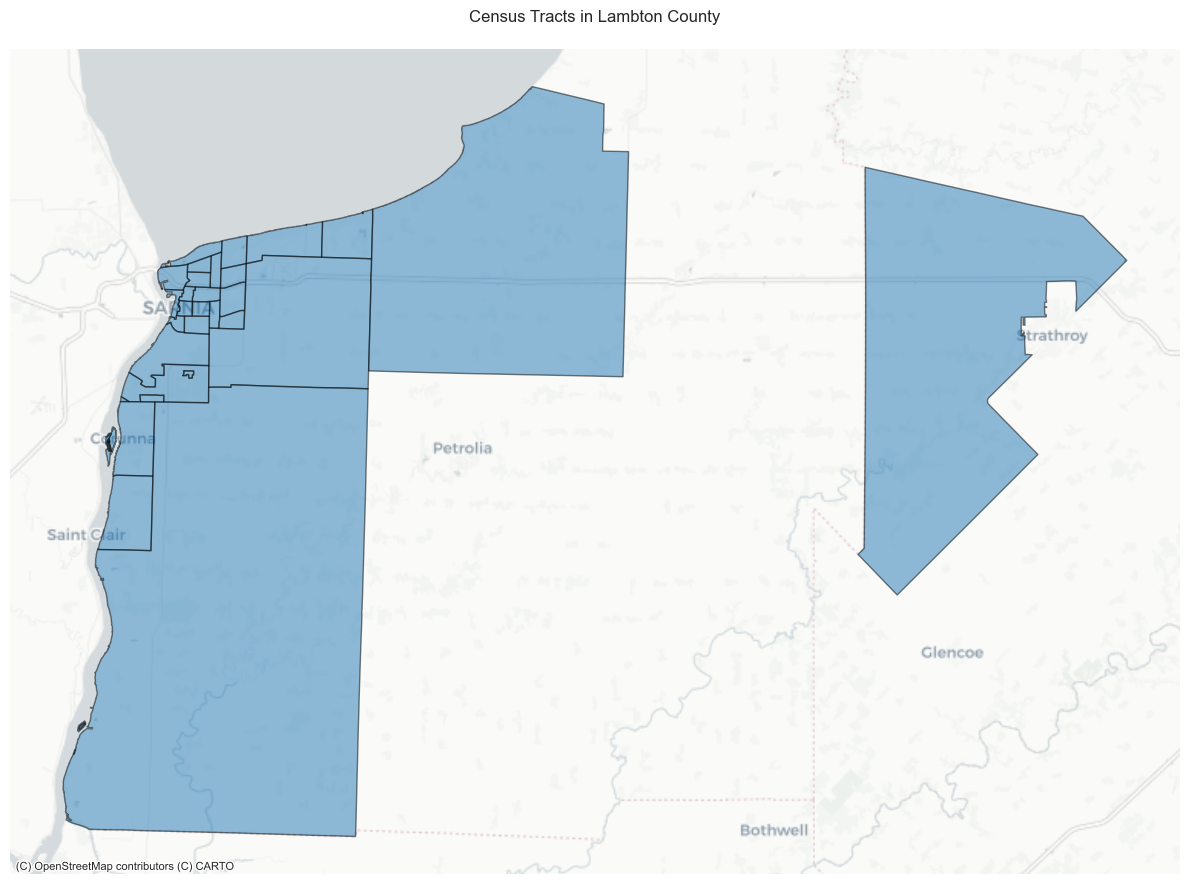


3. ANALYZING ALL CENSUS TRACTS

Processing tract 827 of 27

Analyzing tract 5550300.00
-------------------------
1. Downloading street network...
   ✓ Found 169 nodes and 430 edges

2. Fetching amenities and POIs...
  - Fetching restaurants... Found 2 features
 Successfully processed 2 features
  - Fetching shops... Found 1 features
 Successfully processed 1 features
  - Fetching education... Found 1 features
 Successfully processed 1 features
  - Fetching healthcare... Error: No data elements in server response. Check log and query location/tags.
  - Fetching recreation... Found 6 features
 Successfully processed 6 features
  - Fetching parks... Found 2 features
 Successfully processed 2 features
  - Fetching public_transport... Error: No data elements in server response. Check log and query location/tags.
  - Fetching community... Found 10 features
 Successfully processed 10 features
  - Fetching agriculture... Found 18 features
 Successfully processed 18 features
  - Fetching touri

  - Fetching healthcare... Error: No data elements in server response. Check log and query location/tags.
  - Fetching recreation... Found 7 features
 Successfully processed 7 features
  - Fetching parks... Found 3 features
 Successfully processed 3 features
  - Fetching public_transport... Error: No data elements in server response. Check log and query location/tags.
  - Fetching community... Found 3 features
 Successfully processed 3 features
  - Fetching agriculture... Error: No data elements in server response. Check log and query location/tags.
  - Fetching tourism... Found 1 features
 Successfully processed 1 features

✓ Analysis complete for tract 5620008.00

Processing tract 1607 of 27

Analyzing tract 5620009.00
-------------------------
1. Downloading street network...
   ✓ Found 113 nodes and 297 edges

2. Fetching amenities and POIs...
  - Fetching restaurants... Found 12 features
 Successfully processed 12 features
  - Fetching shops... Found 10 features
 Successfully proc

  - Fetching public_transport... Error: No data elements in server response. Check log and query location/tags.
  - Fetching community... Found 3 features
 Successfully processed 3 features
  - Fetching agriculture... Error: No data elements in server response. Check log and query location/tags.
  - Fetching tourism... Error: No data elements in server response. Check log and query location/tags.

✓ Analysis complete for tract 5620001.01

Processing tract 3593 of 27

Analyzing tract 5620001.02
-------------------------
1. Downloading street network...
   ✓ Found 68 nodes and 159 edges

2. Fetching amenities and POIs...
  - Fetching restaurants... Found 2 features
 Successfully processed 2 features
  - Fetching shops... None found
  - Fetching education... None found
  - Fetching healthcare...

C:\Users\user\anaconda3\Lib\site-packages\osmnx\features.py:1053: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  gdf = gdf.dropna(axis="columns", how="all")
C:\Users\user\anaconda3\Lib\site-packages\osmnx\features.py:1053: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  gdf = gdf.dropna(axis="columns", how="all")


 None found
  - Fetching recreation...

C:\Users\user\anaconda3\Lib\site-packages\osmnx\features.py:1053: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  gdf = gdf.dropna(axis="columns", how="all")


 Found 1 features
 Successfully processed 1 features
  - Fetching parks... Found 1 features
 Successfully processed 1 features
  - Fetching public_transport... None found
  - Fetching community...

C:\Users\user\anaconda3\Lib\site-packages\osmnx\features.py:1053: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  gdf = gdf.dropna(axis="columns", how="all")


 Found 2 features
 Successfully processed 2 features
  - Fetching agriculture... Error: No data elements in server response. Check log and query location/tags.
  - Fetching tourism...

C:\Users\user\anaconda3\Lib\site-packages\osmnx\features.py:1053: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  gdf = gdf.dropna(axis="columns", how="all")


 None found

✓ Analysis complete for tract 5620001.02

Processing tract 3900 of 27

Analyzing tract 5620101.01
-------------------------
1. Downloading street network...
   ✓ Found 138 nodes and 333 edges

2. Fetching amenities and POIs...
  - Fetching restaurants... None found
  - Fetching shops...

C:\Users\user\anaconda3\Lib\site-packages\osmnx\features.py:1053: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  gdf = gdf.dropna(axis="columns", how="all")


 Found 2 features
 Successfully processed 2 features
  - Fetching education... Found 2 features
 Successfully processed 2 features
  - Fetching healthcare... Found 4 features
 Successfully processed 4 features
  - Fetching recreation... Found 8 features
 Successfully processed 8 features
  - Fetching parks... Found 5 features
 Successfully processed 5 features
  - Fetching public_transport... Error: No data elements in server response. Check log and query location/tags.
  - Fetching community... Found 1 features
 Successfully processed 1 features
  - Fetching agriculture... None found
  - Fetching tourism...

C:\Users\user\anaconda3\Lib\site-packages\osmnx\features.py:1053: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  gdf = gdf.dropna(axis="columns", how="all")


 Error: No data elements in server response. Check log and query location/tags.

✓ Analysis complete for tract 5620101.01

Processing tract 3901 of 27

Analyzing tract 5620101.02
-------------------------
1. Downloading street network...
   ✓ Found 92 nodes and 212 edges

2. Fetching amenities and POIs...
  - Fetching restaurants... Error: No data elements in server response. Check log and query location/tags.
  - Fetching shops... Error: No data elements in server response. Check log and query location/tags.
  - Fetching education... Error: No data elements in server response. Check log and query location/tags.
  - Fetching healthcare... Error: No data elements in server response. Check log and query location/tags.
  - Fetching recreation... Found 7 features
 Successfully processed 7 features
  - Fetching parks... Found 3 features
 Successfully processed 3 features
  - Fetching public_transport... Error: No data elements in server response. Check log and query location/tags.
  - Fetch

  - Fetching shops... Found 1 features
 Successfully processed 1 features
  - Fetching education... Found 3 features
 Successfully processed 3 features
  - Fetching healthcare... Error: No data elements in server response. Check log and query location/tags.
  - Fetching recreation... Found 6 features
 Successfully processed 6 features
  - Fetching parks... Found 5 features
 Successfully processed 5 features
  - Fetching public_transport... Error: No data elements in server response. Check log and query location/tags.
  - Fetching community... Found 8 features
 Successfully processed 8 features
  - Fetching agriculture... Error: No data elements in server response. Check log and query location/tags.
  - Fetching tourism... Found 1 features
 Successfully processed 1 features

✓ Analysis complete for tract 5620110.02

Processing tract 3909 of 27

Analyzing tract 5620110.03
-------------------------
1. Downloading street network...
   ✓ Found 377 nodes and 1106 edges

2. Fetching amenities

C:\Users\user\anaconda3\Lib\site-packages\osmnx\features.py:1053: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  gdf = gdf.dropna(axis="columns", how="all")


 None found
  - Fetching education...

C:\Users\user\anaconda3\Lib\site-packages\osmnx\features.py:1053: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  gdf = gdf.dropna(axis="columns", how="all")


 Found 7 features
 Successfully processed 7 features
  - Fetching healthcare... None found
  - Fetching recreation...

C:\Users\user\anaconda3\Lib\site-packages\osmnx\features.py:1053: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  gdf = gdf.dropna(axis="columns", how="all")


 Found 46 features
 Successfully processed 46 features
  - Fetching parks... Found 27 features
 Successfully processed 27 features
  - Fetching public_transport... None found
  - Fetching community...

C:\Users\user\anaconda3\Lib\site-packages\osmnx\features.py:1053: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  gdf = gdf.dropna(axis="columns", how="all")


 Found 27 features
 Successfully processed 27 features
  - Fetching agriculture... Found 4 features
 Successfully processed 4 features
  - Fetching tourism... Found 5 features
 Successfully processed 5 features

✓ Analysis complete for tract 5620110.03

Processing tract 4171 of 27

Analyzing tract 5620120.00
-------------------------
1. Downloading street network...
   ✓ Found 425 nodes and 1118 edges

2. Fetching amenities and POIs...
  - Fetching restaurants... Error: No data elements in server response. Check log and query location/tags.
  - Fetching shops... Found 1 features
 Successfully processed 1 features
  - Fetching education... Found 7 features
 Successfully processed 7 features
  - Fetching healthcare... Error: No data elements in server response. Check log and query location/tags.
  - Fetching recreation... Found 26 features
 Successfully processed 26 features
  - Fetching parks... Found 15 features
 Successfully processed 15 features
  - Fetching public_transport... Found

In [3]:
def create_summary_report(lambton_tracts_with_metrics, locations_df):
    """
    Create a summary report of the analysis for Lambton County using both tract metrics and location data
    """
    print("\n5. GENERATING SUMMARY REPORT")
    print("============================")
    
    try:
        # Calculate counts by category
        category_counts = locations_df['category'].value_counts()
        
        # Calculate densities
        total_area = lambton_tracts_with_metrics['area_km2'].sum()
        
        summary = {
            'Total Amenities': len(locations_df),
            'Total Restaurants': category_counts.get('restaurants', 0),
            'Total Shops': category_counts.get('shops', 0),
            'Total Educational Facilities': category_counts.get('education', 0),
            'Total Healthcare Facilities': category_counts.get('healthcare', 0),
            'Total Parks & Nature Areas': category_counts.get('parks', 0),
            'Total Community Centers': category_counts.get('community', 0),
            'Total Agricultural Sites': category_counts.get('agriculture', 0),
            'Total Tourism Facilities': category_counts.get('tourism', 0),
            'Total Road Length (km)': lambton_tracts_with_metrics['total_edge_length_km'].sum(),
            'Average Edge Density': lambton_tracts_with_metrics['edge_density_km'].mean(),
            'Total Area (km²)': total_area,
            'Overall Amenity Density (per km²)': len(locations_df) / total_area if total_area > 0 else 0
        }
        
        print("\nLambton County Summary Statistics:")
        print("-" * 50)
        for key, value in summary.items():
            print(f"{key}: {value:.2f}")
            
        return pd.Series(summary)
        
    except Exception as e:
        print(f"\n✗ Error generating summary report: {str(e)}")
        return None
    
def visualize_amenities(lambton_tracts_with_metrics, locations_df):
    """
    Create a single visualization of all amenities in Lambton County with colored dots
    and clearly visible street layout using folium
    """
    print("\nCREATING VISUALIZATION")
    print("=====================")
    
    try:
        # Calculate center of Lambton County
        center_lat = locations_df['latitude'].mean()
        center_lon = locations_df['longitude'].mean()
        
        # Create a folium map centered on Lambton County
        m = folium.Map(
            location=[center_lat, center_lon],
            zoom_start=10,  # Reduced zoom level to show more area
            tiles='cartodbpositron'
        )
        
        # Define colors for each category
        category_colors = {
            'shops': '#4285F4',        # Blue
            'recreation': '#34A853',    # Green
            'community': '#9334E6',     # Purple
            'restaurants': '#EA4335',   # Red
            'education': '#FBBC05',     # Yellow/Gold
            'healthcare': '#8B0000',    # Dark Red
            'parks': '#90EE90',         # Light Green
            'public_transport': '#48D1CC', # Turquoise
            'agriculture': '#8B4513',    # Brown
            'tourism': '#FF69B4'         # Pink
        }
        
        # Add census tracts to the map
        folium.GeoJson(
            lambton_tracts_with_metrics,
            style_function=lambda x: {
                'fillColor': 'white',
                'fillOpacity': 0.1,
                'color': 'gray',
                'weight': 0.5
            },
            tooltip=folium.GeoJsonTooltip(
                fields=['CTUID'],
                aliases=['Census Tract:'],
                style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;")
            )
        ).add_to(m)
        
        # Create feature groups for each category
        feature_groups = {category: folium.FeatureGroup(name=f"{category.title()} ({len(locations_df[locations_df['category'] == category])})") 
                        for category in category_colors.keys()}
        
        # Add points to respective feature groups
        for idx, row in locations_df.iterrows():
            color = category_colors.get(row['category'], '#808080')  # Default gray for unknown categories
            folium.CircleMarker(
                location=[row['latitude'], row['longitude']],
                radius=6,
                color=color,
                fill=True,
                fillColor=color,
                fillOpacity=0.8,
                weight=1,
                popup=folium.Popup(
                    f"<b>{row.get('name', 'Unnamed')}</b><br>"
                    f"Type: {row.get('type_description', 'Unknown')}<br>"
                    f"Category: {row.get('category', 'Unknown')}",
                    max_width=200
                )
            ).add_to(feature_groups[row['category']])
        
        # Add all feature groups to map
        for group in feature_groups.values():
            group.add_to(m)
        
        # Add layer control
        folium.LayerControl().add_to(m)
        
        # Save the map
        m.save('lambton_county_amenities.html')
        print("Map saved as 'lambton_county_amenities.html'")
        
        return m
        
    except Exception as e:
        print(f"Error creating visualization: {str(e)}")
        raise

def run_analysis():
    """
    Main function to run the complete Lambton County analysis
    """
    print("\nLAMBTON COUNTY CENSUS TRACT ANALYSIS")
    print("====================================")
    
    try:
        # Download and prepare data
        shapefile_path = download_census_tracts()
        lambton_tracts = get_lambton_tracts(shapefile_path)
        
        # Analyze features
        lambton_tracts_with_metrics = analyze_all_tracts(lambton_tracts)
        
        if lambton_tracts_with_metrics is None:
            print("\n✗ Analysis failed - no metrics to visualize")
            return None, None
            
        # Load the locations data
        try:
            locations_df = pd.read_csv('lambton_county_locations.csv')
            print(f"\nLoaded {len(locations_df)} locations from data file")
            
            # Create visualizations
            visualize_amenities(lambton_tracts_with_metrics, locations_df)
            
            # Generate summary
            create_summary_report(lambton_tracts_with_metrics, locations_df)
            
        except Exception as e:
            print(f"\n✗ Error loading locations data: {str(e)}")
        
        return lambton_tracts_with_metrics, locations_df
        
    except Exception as e:
        print(f"\n✗ Error in main execution: {str(e)}")
        return None, None

if __name__ == "__main__":
    lambton_tracts_with_metrics, locations_df = run_analysis()

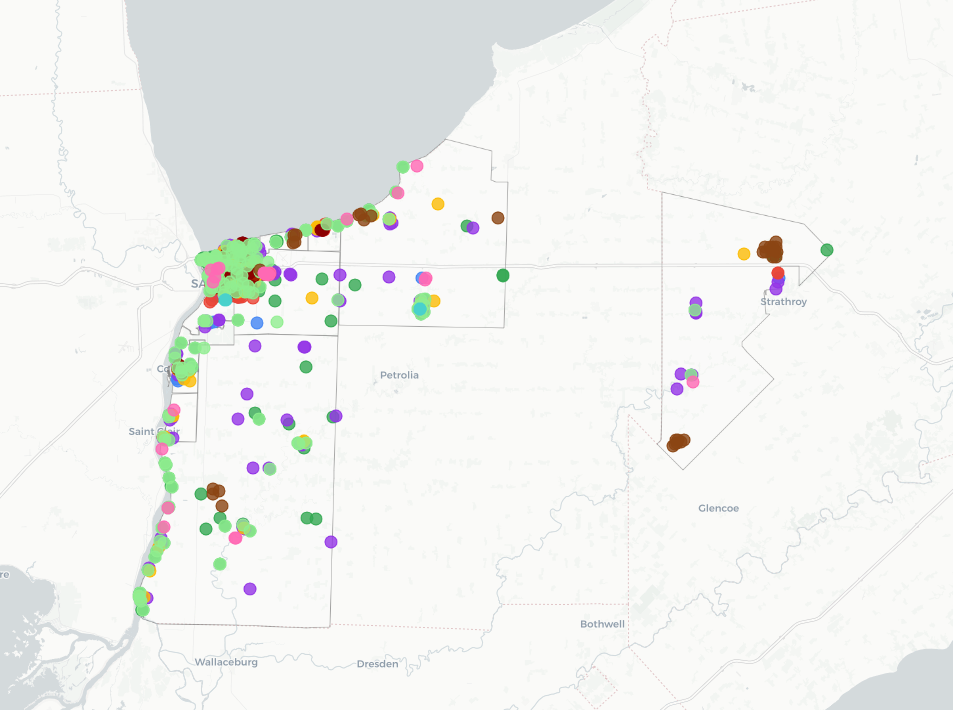